# Imports

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from strategy_gameplay import AgentFactory

In [2]:
TYPES = [
    'public_based',
    'relation_based',
    'popularity_based'
]
EXPERIMENT_TYPE = TYPES[2]

# Load the data

In [3]:
graph_df = pd.read_csv('data/coauth-MAG-gr3-downsampled.txt', delimiter=' ', header=None, names=['source', 'target', 'strength'])
graph_df.head(10)

,source,target,strength
0,26396074,5199,4
1,37546,37545,6
2,37545,37546,6
3,9751190,35868,7
4,72205406,32647,8
5,2985,2986,4
6,8757512,13982,6
7,6530,6529,5
8,6529,6530,5
9,15577207,20103,5


In [4]:
graph_df['node1'] = graph_df[['source', 'target']].min(axis=1)
graph_df['node2'] = graph_df[['source', 'target']].max(axis=1)

In [5]:
graph_df = graph_df[['node1', 'node2', 'strength']]

In [6]:
graph_df

,node1,node2,strength
0,5199,26396074,4
1,37545,37546,6
2,37545,37546,6
3,35868,9751190,7
4,32647,72205406,8
...,...,...,...
838953,1720025,8592380,5
838954,26376,7610000,9
838955,1916294,5197935,9
838956,13567,5197935,11


# Generate the agents

In [7]:
people = list(pd.concat([graph_df['node1'], graph_df['node2']]).unique())
people = sorted(people)

print(len(people))

100026


In [8]:
agent_type = ['lazy' for _ in range(int(len(people) * 0.1))] + ['workaholic' for _ in range(int(len(people) * 0.1))]
agent_type += [EXPERIMENT_TYPE for _ in range(len(people) - len(agent_type))]

print(len(agent_type))

100026


In [9]:
agents = AgentFactory.generate_agents(agent_type)

100%|██████████| 100026/100026 [00:00<00:00, 198995.42it/s]


In [10]:
agent_dict = dict()

for id, agent in zip(people, agents):
    agent_dict[id] = agent

# Experiment Setup

In [11]:
ENVIRONMENT = {
    'R': 5,
    'S': -10,
    'T': 10,
    'P': -5
}

In [12]:
class Graph:
    def __init__(self, graph_df, agent_dict, environment):
        self.environment = environment
        self.agent_dict = agent_dict
        
        self.adj_list = dict()
        self.strength = dict()
        self.popularity = dict()
        
        self.public_work_ethic = 0.5
        
        for row in tqdm(graph_df.itertuples(), total=len(graph_df), desc='Building Graph'):
            node1, node2 = min(row.node1, row.node2), max(row.node1, row.node2)
            strength = row.strength
            
            if node1 not in self.adj_list:
                self.adj_list[node1] = set()
            if node2 not in self.adj_list:
                self.adj_list[node2] = set()
                
            self.adj_list[node1].add(node2)
            self.adj_list[node2].add(node1)
            
            self.strength[(node1, node2)] = strength
            self.strength[(node2, node1)] = strength
            
            self.popularity[node1] = 0
            self.popularity[node2] = 0
            
    def generate_state(self, node, neighbor):
        return {
            'relation_strength': self.get_strength(node, neighbor),
            'popularity': self.popularity[neighbor],
            'public_work_ethic': self.public_work_ethic
        }
        

    def simulate_one_step(self, ith = 0):
        count_lazy = 0
        count_work = 0
        
        for node in tqdm(self.adj_list, total=len(self.adj_list), desc=f'Simulating {ith + 1} Step'):
            selected_neighbor = np.random.choice(list(self.adj_list[node]))
            
            state1 = self.generate_state(node, selected_neighbor)
            state2 = self.generate_state(selected_neighbor, node)
            
            agent1 = self.agent_dict[node]
            agent2 = self.agent_dict[selected_neighbor]

            action1 = agent1.get_action(state1)
            action2 = agent2.get_action(state2)
            
            self.update_popularity(node, action1, delta=5)
            self.update_popularity(selected_neighbor, action2, delta=5)
            
            if action1 == 'work' and action2 == 'work':
                self.update_strength(node, selected_neighbor, self.environment['R'])
                self.update_strength(selected_neighbor, node, self.environment['R'])
                
            if action1 == 'work' and action2 == 'lazy':
                self.update_strength(node, selected_neighbor, self.environment['S'])
                self.update_strength(selected_neighbor, node, self.environment['T'])
                
            if action1 == 'lazy' and action2 == 'work':
                self.update_strength(node, selected_neighbor, self.environment['T'])
                self.update_strength(selected_neighbor, node, self.environment['S'])
                
            if action1 == 'lazy' and action2 == 'lazy':
                self.update_strength(node, selected_neighbor, self.environment['P'])
                self.update_strength(selected_neighbor, node, self.environment['P'])
                
            if action1 == 'lazy':
                count_lazy += 1
            else:
                count_work += 1
                
            if action2 == 'lazy':
                count_lazy += 1
            else:
                count_work += 1
        
        # Update public work ethic
        self.public_work_ethic = count_work / (count_work + count_lazy)
        
        # Return the number of lazy and workaholic agents
        return count_lazy, count_work
    

    # ----------------------------------- #
    #        Getters and Setters          #
    # ----------------------------------- #

    def get_neighbors(self, node):
        return self.adj_list[node]
    
    def get_strength(self, node1, node2):
        return self.strength[(node1, node2)]
    
    def update_strength(self, node1, node2, delta):
        self.strength[(node1, node2)] += delta
    
    def get_strengths(self):
        return list(self.strength.values())
    
    def get_mean_strength(self):
        return np.mean(self.get_strengths())
    
    def get_median_strength(self):
        return np.median(self.get_strengths())
    
    def update_popularity(self, node, action, delta = 1):
        if action == 'work':
            self.popularity[node] += delta
        elif action == 'lazy':
            self.popularity[node] -= delta   
        else:
            raise ValueError('Invalid action')


# Experiments

In [13]:
def do_experiment():
    g = Graph(graph_df, agent_dict, ENVIRONMENT)
    mean_strengths = [g.get_mean_strength()]
    number_of_work = [0]
    number_of_lazy = [0]

    for ith in range(10):
        lazy_cnt, work_cnt = g.simulate_one_step(ith)
        mean_strengths.append(g.get_mean_strength())
        
        number_of_work.append(work_cnt)
        number_of_lazy.append(lazy_cnt)
        
    return [mean_strengths, number_of_work, number_of_lazy]

In [14]:
experiments = [do_experiment() for _ in range(5)]

Simulating 5 Step:  98%|█████████▊| 97788/100026 [00:28<00:00, 3456.21it/s]d:\Documents\Obrazovanie\Fakultet\Semestar 6\Fakultet-Proekti\Agentno-Proekt\strategy_gameplay\strategies\popularity_based.py:15: RuntimeWarning: overflow encountered in exp
  prob_work = 1/(1+np.exp(-(popularity)/2))
Simulating 10 Step: 100%|██████████| 100026/100026 [00:31<00:00, 3157.56it/s]


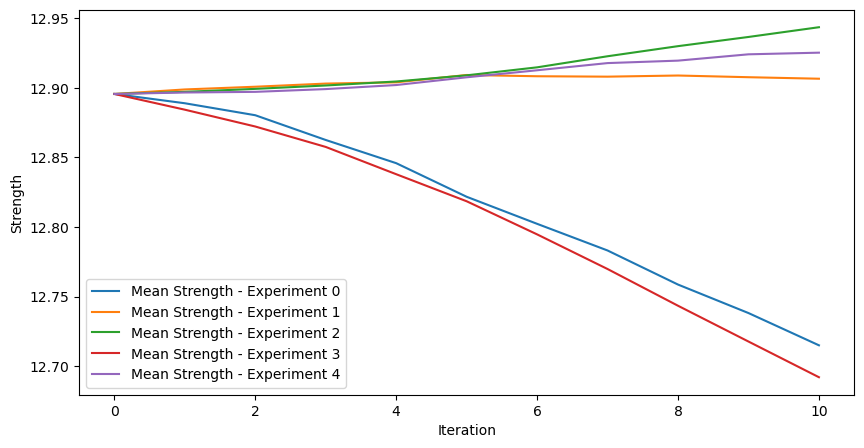

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
for i, ms in enumerate(experiments):
    plt.plot(ms[0], label=f'Mean Strength - Experiment {i}')

plt.xlabel('Iteration')
plt.ylabel('Strength')

plt.legend()
plt.show()

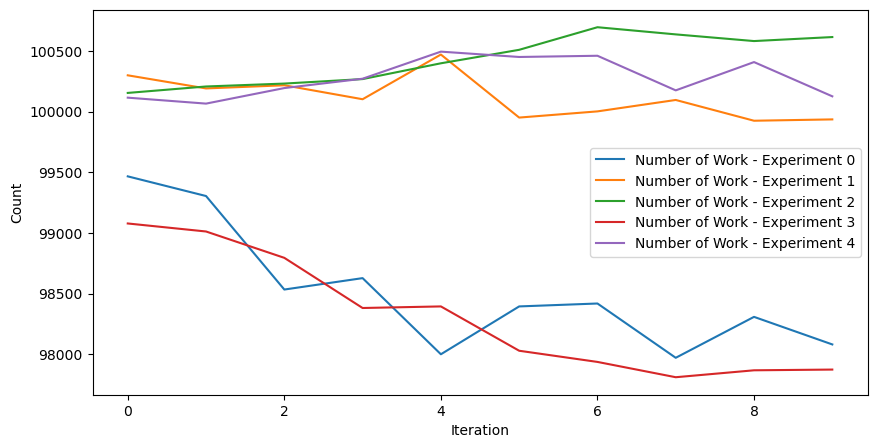

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
for i, ms in enumerate(experiments):
    plt.plot(ms[1][1:], label=f'Number of Work - Experiment {i}')

plt.xlabel('Iteration')
plt.ylabel('Count')

plt.legend()
plt.show()

In [17]:
np_results = np.array(experiments)
np.save(f'results/saved_results_{EXPERIMENT_TYPE}_radical.npy', np_results)